# Multi-class Dog Breed Classification
Multiclass Dog Breed classification model build with TensorFlow and TensorFlow Hub

## 1. Problem
Given an image of a dog, asked to identify its breed.

## 2. Data
Data used is taken from Stanford University Dogs Dataset http://vision.stanford.edu/aditya86/ImageNetDogs/

## 3. Evaluation
The resultant model will be evaluated based on the Multi-class Log Loss.

## 4. Features
- Unstructured data (images)
- 120 Categories (dog breeds)
- Total of 20580 unique images.
- Approximately 150 images per breed.

# First, We Need to Prepare Libraries

In [2]:
#Import libraries
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

#Check whether theres GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.6.4
TF Hub version: 0.12.0
GPU available


2022-08-16 00:48:49.242253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 00:48:49.394357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 00:48:49.395664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data Preparation
## Retrieve the image classes (120 Unique Dog Breeds)

In [3]:
unique_breeds = []

for folders in os.listdir("../input/stanford-dogs-dataset/images/Images"):
    breed = "".join(folders.split("-")[1:])
    unique_breeds.append(breed)
    
# Converts to sorted ndarray
unique_breeds = np.array(sorted(unique_breeds))
len(unique_breeds), unique_breeds[:10]

(120,
 array(['Afghan_hound', 'African_hunting_dog', 'Airedale',
        'American_Staffordshire_terrier', 'Appenzeller',
        'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog',
        'Blenheim_spaniel', 'Border_collie'], dtype='<U30'))

## Create a function to do all the pre-processing in one go (Data Pipeline)

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

#Image Data Pipeline Function
def image_data_pipeline(path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, test_data=False, seed=42):
    """
    Reads images from path, and splits them into training and validation sets
    Create batches of data out of (image x) and (label y) pairs.
    Returns two data batches training_batch and validation_batch.

    Also accepts test data as input (no labels).
    """
    
    # Function for retrieving data
    def retrieve_data_from_path(path, test_data=False):
        filenames = []
        # Test data image retrieval (not separated per class)
        if test_data:
            for files in os.listdir(path):
                filenames.append(f"{path}/{files}")
            return np.array(filenames)
        
        # Train and val data image retrieval
        else:
            for folders in os.listdir(path):
                for files in os.listdir(f"{path}/{folders}"):
                    filenames.append(f"{path}/{folders}/{files}")
            filenames = np.array(filenames)
            np.random.shuffle(filenames)
            labels = np.array(["".join(name.split('/')[-2].split("-")[1:]) for name in filenames])
            unique_breeds = np.unique(labels)
            boolean_labels = np.array([label == unique_breeds for label in labels]).astype(int)
            return filenames, boolean_labels

    #Function for preprocessing
    def process_image(filename, img_size=IMG_SIZE):
        #read image
        image = tf.io.read_file(filename)

        #turn jpeg to numerical Tensor with 3 color channels (RGB)
        image = tf.image.decode_jpeg(image, channels=3)

        #Convert colour channels values 0-255 to 0-1 values.
        #This is a normalization process to make process more efficient.
        image = tf.image.convert_image_dtype(image, tf.float32)

        #Resize to (224,224)
        image = tf.image.resize(image, size=[img_size, img_size])

        return image
    
    # Function for data configuration (for performance) 
    def configure_tensor(ds, shuffle=False):
        if shuffle: # For train set
            ds = ds.shuffle(buffer_size=1000) 
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds
    
    # ----------------------------------------------------------------------------------
    
    # Test data pipeline
    if test_data:
        print(f"Creating test data batches... BATCH SIZE={batch_size}")
        x = retrieve_data_from_path(path, test_data=True)
        x_test = tf.data.Dataset.from_tensor_slices(x).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return configure_tensor(x_test)
    
    # Train and validation data pipeline
    else:
        print(f"Creating train & validation data batches... BATCH SIZE={batch_size}")
        x, y = retrieve_data_from_path(path)
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)
        x_train = tf.data.Dataset.from_tensor_slices(x_train).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        x_valid = tf.data.Dataset.from_tensor_slices(x_valid).map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        y_train = tf.data.Dataset.from_tensor_slices(y_train)
        y_valid = tf.data.Dataset.from_tensor_slices(y_valid)
        train_data = tf.data.Dataset.zip((x_train, y_train)) 
        valid_data = tf.data.Dataset.zip((x_valid, y_valid)) 
        return configure_tensor(train_data, shuffle=True), configure_tensor(valid_data)
    
  

## Generate Train and Validation Data for Base Training (No augmentation)

In [5]:
path = "../input/stanford-dogs-dataset/images/Images"
train_data, valid_data = image_data_pipeline(path)
train_data.element_spec, valid_data.element_spec

Creating train & validation data batches... BATCH SIZE=32


2022-08-16 00:48:51.892589: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-16 00:48:51.893140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 00:48:51.894052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 00:48:51.894792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.int64, name=None)))

## Visualize the generated image batches

2022-08-15 13:13:12.706273: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


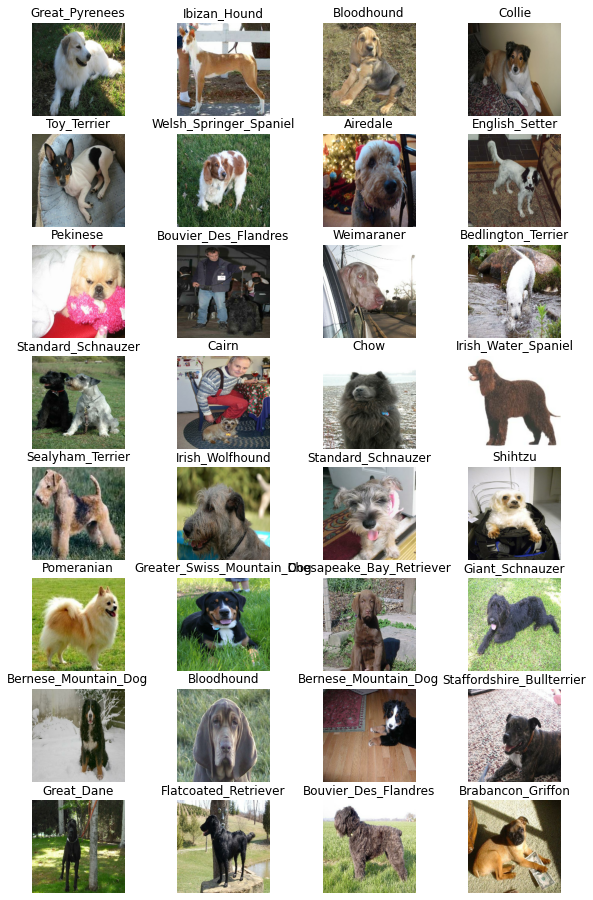

In [9]:
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,16))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(8,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(unique_breeds[label_batch[n]==1][0].title(), fontsize=12)
      plt.axis('off')
    
image_batch, label_batch = next(train_data.as_numpy_iterator())
show_batch(image_batch, label_batch)

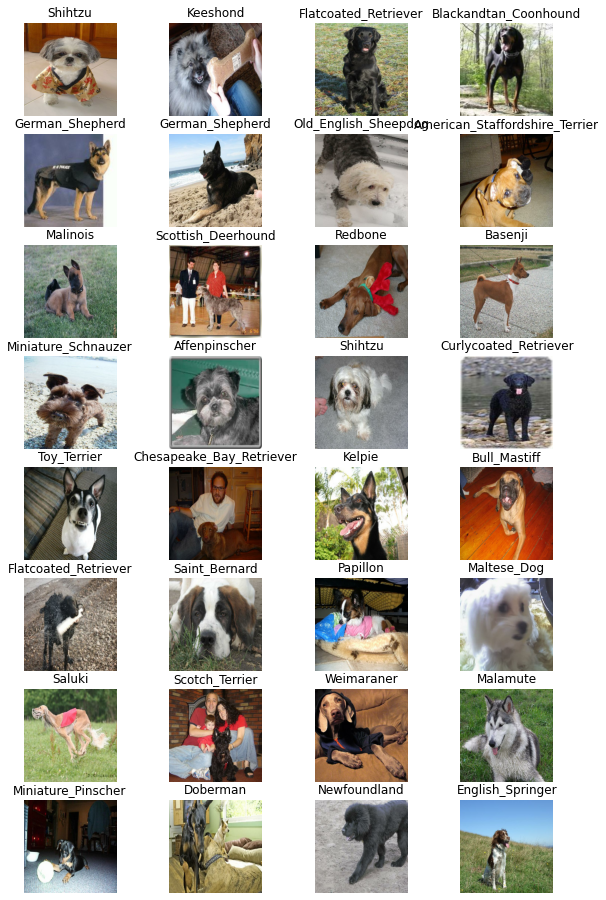

In [7]:
valid_image, valid_label = next(valid_data.as_numpy_iterator())
show_batch(valid_image, valid_label)

# Building a Model !

Before we build a model, there are a few things we need to define:
* The input shape (image shape in the form of Tensors)
* The output shape (image labels in the form of Tensors)
* URL of model we want to use Transfer Learning with from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5

^^ MobileNetV3 Image Classification (Size = 224x224, Depth Multiplier = 1.0)

In [7]:
#setup input shape into the model
INPUT_SHAPE = [IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channel

#setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

#setup model URL from Tensorflow HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5"

Now we've got our Inputs, Outputs, and Model ready...
Lets put them together into a Keras Deep Learning Model!

Knowing this, let's:
* Defines the layers of KEras Model in a sequential fashion
* Compiles the model (Says it should be evaluated and improved)
* Builds model (Tell model the input shape it'll be getting)

All the steps can be found in https://www.tensorflow.org/guide/keras/overview

In [6]:
# Pre-trained base Model
base_model = hub.KerasLayer(MODEL_URL)
base_model.trainable = False

# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)       
])

# Compiling the model
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE,)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5508713   
_________________________________________________________________
dense (Dense)                (None, 512)               513024    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 6,183,905
Trainable params: 675,192
Non-trainable params: 5,508,713
________________________________________

In [9]:
# Pre-trained base Model
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [28]:
# Setup Layers
model = tf.keras.Sequential([
    base_model, # Layer 1 (Input Layer)
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1024, activation="relu"), # Hidden Layer
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512, activation="relu"), # Hidden Layer   
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation="relu"), # Hidden Layer       
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") # Layer 4 (Output Layer)       
])


# Compiling the model
base_learning_rate = 0.0001
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
      metrics =["accuracy"]
)

# Build Model
model.build(INPUT_SHAPE)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

In [29]:
len(model.trainable_variables)

8

## Creating Callbacks

Callbacks are helper functions a model can use during training to:
* Save its progress
* Check its progress
* Stop Training early if it stops improving

We'll create 2 callbacks,
- One is for Model Checkpoint, helps track and save our model
- Second is for early stopping, prevents model from training too long (becoming overfitted)

There is also a useful callback called TensorBoard but it is currently not working in Kaggle.
### TensorBoard Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

To setup the Tensorboard Callback, we need to:
1. Load a TensorBoard notebook Extension
2. Create a Tensorboard Callback which save logs to a directory and pass it to the model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

### Model Checkpoint Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

Callback to save the Keras model or model weights at some frequency.

In [17]:
def create_model_checkpoint(dir, suffix=None):
    modeldir = os.path.join(dir, "Models",
                          datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%s"))
    
    model_path = modeldir + "-" + suffix
    print(f"Model will be saved to `{model_path}`")
    return tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_accuracy',save_best_only=True)

### Early Stopping Callback
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

Helps model from overfitting by stopping training if a certain evaluation metric stops improving

In [18]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Train the model
## NOW, lets train the mode with the full data (20580 images)

In [30]:
init_loss, init_acc = model.evaluate(valid_data)

129/129 [==============================] - 12s 84ms/step - loss: 4.8447 - accuracy: 0.0141


In [31]:
# Metrics before training (very poor performance)
print("initial loss: {:.2f}".format(init_loss))
print("initial accuracy: {:.2f}".format(init_acc))

initial loss: 4.84
initial accuracy: 0.01


In [32]:
# EPOCHS
NUM_EPOCHS = 100

# Create callback
checkpoint = create_model_checkpoint("Notebook_Outputs", "MobileNetV2_100_Adam_20580")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)

# Model Training
model_history = model.fit(x=train_data,
                    epochs=NUM_EPOCHS,
                    validation_data=valid_data,
                    validation_freq=1,
                    callbacks=[early_stopping, checkpoint],
                )

Model will be saved to `Notebook_Outputs/Models/2022_08_16-01_22_1660612971-MobileNetV2_100_Adam_20580`
Epoch 1/100
 39/515 [=>............................] - ETA: 40s - loss: 4.7590 - accuracy: 0.0272

Cleanup called...


515/515 [==============================] - 56s 101ms/step - loss: 2.8171 - accuracy: 0.3557 - val_loss: 1.0777 - val_accuracy: 0.7053


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
 40/515 [=>............................] - ETA: 39s - loss: 1.4787 - accuracy: 0.5945

Cleanup called...


515/515 [==============================] - 54s 99ms/step - loss: 1.2143 - accuracy: 0.6485 - val_loss: 0.8543 - val_accuracy: 0.7483


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
 40/515 [=>............................] - ETA: 38s - loss: 1.1101 - accuracy: 0.6711

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.9537 - accuracy: 0.7184 - val_loss: 0.8117 - val_accuracy: 0.7585


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
 40/515 [=>............................] - ETA: 45s - loss: 0.8665 - accuracy: 0.7383

Cleanup called...


515/515 [==============================] - 54s 100ms/step - loss: 0.8125 - accuracy: 0.7528 - val_loss: 0.7644 - val_accuracy: 0.7692


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/100
 40/515 [=>............................] - ETA: 42s - loss: 0.7580 - accuracy: 0.7805

Cleanup called...


515/515 [==============================] - 53s 99ms/step - loss: 0.7124 - accuracy: 0.7812 - val_loss: 0.7478 - val_accuracy: 0.7750


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
 40/515 [=>............................] - ETA: 39s - loss: 0.6855 - accuracy: 0.7742

Cleanup called...


515/515 [==============================] - 53s 97ms/step - loss: 0.6211 - accuracy: 0.8061 - val_loss: 0.7403 - val_accuracy: 0.7731
Epoch 7/100
 40/515 [=>............................] - ETA: 41s - loss: 0.5889 - accuracy: 0.8219

Cleanup called...


515/515 [==============================] - 53s 99ms/step - loss: 0.5572 - accuracy: 0.8263 - val_loss: 0.7368 - val_accuracy: 0.7750
Epoch 8/100
 40/515 [=>............................] - ETA: 37s - loss: 0.5265 - accuracy: 0.8258

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.4917 - accuracy: 0.8425 - val_loss: 0.7365 - val_accuracy: 0.7816


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/100
 40/515 [=>............................] - ETA: 42s - loss: 0.4269 - accuracy: 0.8609

Cleanup called...


515/515 [==============================] - 53s 99ms/step - loss: 0.4400 - accuracy: 0.8595 - val_loss: 0.7292 - val_accuracy: 0.7860


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
 40/515 [=>............................] - ETA: 37s - loss: 0.3920 - accuracy: 0.8805

Cleanup called...


515/515 [==============================] - 53s 97ms/step - loss: 0.3967 - accuracy: 0.8720 - val_loss: 0.7568 - val_accuracy: 0.7816
Epoch 11/100
 40/515 [=>............................] - ETA: 40s - loss: 0.3650 - accuracy: 0.8930

Cleanup called...


515/515 [==============================] - 53s 99ms/step - loss: 0.3508 - accuracy: 0.8866 - val_loss: 0.7318 - val_accuracy: 0.7881


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
 40/515 [=>............................] - ETA: 38s - loss: 0.3419 - accuracy: 0.8961

Cleanup called...


515/515 [==============================] - 53s 99ms/step - loss: 0.3208 - accuracy: 0.8960 - val_loss: 0.7442 - val_accuracy: 0.7804
Epoch 13/100
 40/515 [=>............................] - ETA: 46s - loss: 0.3198 - accuracy: 0.8938

Cleanup called...


515/515 [==============================] - 55s 102ms/step - loss: 0.2775 - accuracy: 0.9122 - val_loss: 0.7528 - val_accuracy: 0.7855
Epoch 14/100
 40/515 [=>............................] - ETA: 38s - loss: 0.2783 - accuracy: 0.9055

Cleanup called...


515/515 [==============================] - 54s 100ms/step - loss: 0.2473 - accuracy: 0.9189 - val_loss: 0.7646 - val_accuracy: 0.7826
Epoch 15/100
 40/515 [=>............................] - ETA: 42s - loss: 0.2380 - accuracy: 0.9266

Cleanup called...


515/515 [==============================] - 55s 101ms/step - loss: 0.2261 - accuracy: 0.9277 - val_loss: 0.7880 - val_accuracy: 0.7809
Epoch 16/100
 40/515 [=>............................] - ETA: 41s - loss: 0.2126 - accuracy: 0.9328

Cleanup called...


515/515 [==============================] - 54s 100ms/step - loss: 0.2014 - accuracy: 0.9382 - val_loss: 0.7892 - val_accuracy: 0.7855
Epoch 17/100
 40/515 [=>............................] - ETA: 38s - loss: 0.1941 - accuracy: 0.9391

Cleanup called...


515/515 [==============================] - 54s 101ms/step - loss: 0.1770 - accuracy: 0.9444 - val_loss: 0.8128 - val_accuracy: 0.7796
Epoch 18/100
 40/515 [=>............................] - ETA: 41s - loss: 0.1534 - accuracy: 0.9523

Cleanup called...


515/515 [==============================] - 55s 101ms/step - loss: 0.1537 - accuracy: 0.9512 - val_loss: 0.8168 - val_accuracy: 0.7843
Epoch 19/100
 40/515 [=>............................] - ETA: 38s - loss: 0.1582 - accuracy: 0.9578

Cleanup called...


515/515 [==============================] - 55s 102ms/step - loss: 0.1395 - accuracy: 0.9583 - val_loss: 0.8145 - val_accuracy: 0.7864
Epoch 20/100
 40/515 [=>............................] - ETA: 38s - loss: 0.1272 - accuracy: 0.9625

Cleanup called...


515/515 [==============================] - 55s 102ms/step - loss: 0.1274 - accuracy: 0.9611 - val_loss: 0.8373 - val_accuracy: 0.7830
Epoch 21/100
 40/515 [=>............................] - ETA: 38s - loss: 0.1191 - accuracy: 0.9633

Cleanup called...


515/515 [==============================] - 54s 100ms/step - loss: 0.1162 - accuracy: 0.9656 - val_loss: 0.8584 - val_accuracy: 0.7792


## Model Learning Curves (Accuracy/Loss)

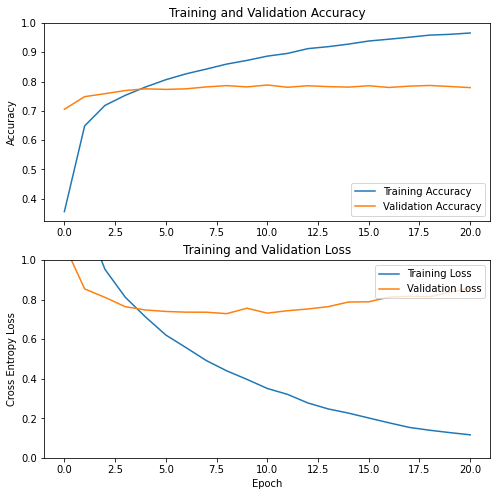

In [33]:
def plot_learning_curves(model_history):
    # retrieve learning metrics history 
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss =model_history.history['val_loss']

    # Plot
    fig = plt.figure(figsize=(8,8))
    ax_acc = plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()), 1])
    plt.title("Training and Validation Accuracy",)
    
    ax_loss = plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy Loss')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_learning_curves(model_history)

In [36]:
load_model = tf.keras.models.load_model("Notebook_Outputs/Models/2022_08_16-01_22_1660612971-MobileNetV2_100_Adam_20580")
base_loss, base_acc = load_model.evaluate(valid_data)

129/129 [==============================] - 12s 83ms/step - loss: 0.7318 - accuracy: 0.7881


In [42]:
# Metrics after training (decent performance)
print("{0:<10}|  {1:<10}{2:<10}".format("METRICS", "INITIAL", "TRAINED"))
print("-"*30)
print("{0:<10}|  {1:<10.5f}{2:<10.5f}".format("Accuracy", init_acc, base_acc))
print("{0:<10}|  {1:<10.5f}{2:<10.5f}".format("Loss", init_loss, base_loss))

METRICS   |  INITIAL   TRAINED   
------------------------------
Accuracy  |  0.01409   0.78814   
Loss      |  4.84471   0.73180   


## Fine-tuning

In [59]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [61]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [63]:
load_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
load_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)              

In [62]:
len(load_model.trainable_variables)

8

Let's create a function which trains a model.

* Create a model using `create_model`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, num of epochs to train for (`NUM_EPOCHS`), and callbacks
* Return Model

In [91]:
NUM_EPOCHS = 100

def train_model(train_data, val_data, suffix=None, dir="Notebook_Outputs"):
    """
    Trains a given model and returns the trained version.
    """

    # Create model
    model = create_model()
    
    # Create new TensorBoard session everytime we train the model
    tensorboard = create_tensorboard_callback(dir)
    # Create new Model Checkpoint callback everytime we train the model
    checkpoint = create_model_checkpoint(dir, suffix)

    # Create early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=10)
    # Fit the model
    model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping, checkpoint],
            )
  
    # Return the fitted model
    return model

In [15]:
# Create full model
full_model = train_model(train_data, valid_data, "MobileNetV3_100_Adam_20580")

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5


2022-08-15 06:28:53.015532: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-15 06:28:53.015581: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-15 06:28:53.017559: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-08-15 06:28:53.243819: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-15 06:28:53.244019: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Model will be saved to `Models/2022_08_15-06_28_1660544933-MobileNetV3_100_Adam_20580`
Epoch 1/100


2022-08-15 06:29:01.318166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/515 [..............................] - ETA: 1:55:46 - loss: 5.4135 - accuracy: 0.0312

2022-08-15 06:29:07.316955: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-15 06:29:07.317014: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/515 [..............................] - ETA: 6:26 - loss: 5.5564 - accuracy: 0.0156   

2022-08-15 06:29:07.686344: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-15 06:29:07.687683: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-08-15 06:29:07.879514: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 426 callback api events and 423 activity events. 


  3/515 [..............................] - ETA: 5:00 - loss: 5.4924 - accuracy: 0.0104

2022-08-15 06:29:07.906013: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-15 06:29:07.945172: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/20220815-062853/train/plugins/profile/2022_08_15_06_29_07

2022-08-15 06:29:07.963629: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to Logs/20220815-062853/train/plugins/profile/2022_08_15_06_29_07/147aa371e713.trace.json.gz
2022-08-15 06:29:08.041471: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: Logs/20220815-062853/train/plugins/profile/2022_08_15_06_29_07

2022-08-15 06:29:08.053662: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to Logs/20220815-062853/train/plugins/profile/2022_08_15_06_29_07/147aa371e713.memory_profile.json.gz
2022-08-15 06:29:08.056363: I tensorflow/core/profiler/rpc/client/capture_profile.

 33/515 [>.............................] - ETA: 1:35 - loss: 4.2810 - accuracy: 0.1487

Cleanup called...


515/515 [==============================] - 117s 201ms/step - loss: 1.0958 - accuracy: 0.7208 - val_loss: 0.5806 - val_accuracy: 0.8212


2022-08-15 06:30:52.236208: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
 34/515 [>.............................] - ETA: 41s - loss: 0.4129 - accuracy: 0.8686

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.3708 - accuracy: 0.8863 - val_loss: 0.5679 - val_accuracy: 0.8253
Epoch 3/100
 34/515 [>.............................] - ETA: 35s - loss: 0.2576 - accuracy: 0.9127

Cleanup called...


515/515 [==============================] - 51s 94ms/step - loss: 0.2266 - accuracy: 0.9354 - val_loss: 0.5798 - val_accuracy: 0.8282
Epoch 4/100
 34/515 [>.............................] - ETA: 42s - loss: 0.1606 - accuracy: 0.9586

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.1530 - accuracy: 0.9592 - val_loss: 0.6020 - val_accuracy: 0.8246
Epoch 5/100
 34/515 [>.............................] - ETA: 36s - loss: 0.1164 - accuracy: 0.9752

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.1102 - accuracy: 0.9744 - val_loss: 0.6188 - val_accuracy: 0.8275
Epoch 6/100
 34/515 [>.............................] - ETA: 41s - loss: 0.1108 - accuracy: 0.9706

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.0802 - accuracy: 0.9829 - val_loss: 0.6345 - val_accuracy: 0.8287
Epoch 7/100
 34/515 [>.............................] - ETA: 37s - loss: 0.0822 - accuracy: 0.9816

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0647 - accuracy: 0.9868 - val_loss: 0.6596 - val_accuracy: 0.8282
Epoch 8/100
 34/515 [>.............................] - ETA: 41s - loss: 0.0646 - accuracy: 0.9844

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0517 - accuracy: 0.9903 - val_loss: 0.6833 - val_accuracy: 0.8263
Epoch 9/100
 34/515 [>.............................] - ETA: 36s - loss: 0.0575 - accuracy: 0.9899

Cleanup called...


515/515 [==============================] - 50s 94ms/step - loss: 0.0431 - accuracy: 0.9930 - val_loss: 0.7157 - val_accuracy: 0.8260
Epoch 10/100
 34/515 [>.............................] - ETA: 40s - loss: 0.0498 - accuracy: 0.9917

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.0384 - accuracy: 0.9936 - val_loss: 0.7223 - val_accuracy: 0.8265
Epoch 11/100
 34/515 [>.............................] - ETA: 36s - loss: 0.0378 - accuracy: 0.9945

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0358 - accuracy: 0.9942 - val_loss: 0.7549 - val_accuracy: 0.8275
Epoch 12/100
 34/515 [>.............................] - ETA: 41s - loss: 0.0555 - accuracy: 0.9871

Cleanup called...


515/515 [==============================] - 53s 99ms/step - loss: 0.0328 - accuracy: 0.9944 - val_loss: 0.7684 - val_accuracy: 0.8290
Epoch 13/100
 34/515 [>.............................] - ETA: 37s - loss: 0.0346 - accuracy: 0.9936

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.0319 - accuracy: 0.9945 - val_loss: 0.8242 - val_accuracy: 0.8180
Epoch 14/100
 34/515 [>.............................] - ETA: 37s - loss: 0.0395 - accuracy: 0.9926

Cleanup called...


515/515 [==============================] - 52s 97ms/step - loss: 0.0336 - accuracy: 0.9942 - val_loss: 0.8523 - val_accuracy: 0.8161
Epoch 15/100
 33/515 [>.............................] - ETA: 37s - loss: 0.0266 - accuracy: 0.9943

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0366 - accuracy: 0.9916 - val_loss: 0.8972 - val_accuracy: 0.8132
Epoch 16/100
 34/515 [>.............................] - ETA: 37s - loss: 0.0591 - accuracy: 0.9881

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.0315 - accuracy: 0.9936 - val_loss: 0.9117 - val_accuracy: 0.8205
Epoch 17/100
 34/515 [>.............................] - ETA: 40s - loss: 0.0555 - accuracy: 0.9862

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.0261 - accuracy: 0.9948 - val_loss: 0.9105 - val_accuracy: 0.8161
Epoch 18/100
 34/515 [>.............................] - ETA: 36s - loss: 0.0439 - accuracy: 0.9917

Cleanup called...


515/515 [==============================] - 51s 96ms/step - loss: 0.0235 - accuracy: 0.9960 - val_loss: 0.9242 - val_accuracy: 0.8175
Epoch 19/100
 34/515 [>.............................] - ETA: 40s - loss: 0.0411 - accuracy: 0.9917

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0228 - accuracy: 0.9961 - val_loss: 0.9519 - val_accuracy: 0.8171
Epoch 20/100
 34/515 [>.............................] - ETA: 36s - loss: 0.0425 - accuracy: 0.9936

Cleanup called...


515/515 [==============================] - 51s 95ms/step - loss: 0.0233 - accuracy: 0.9964 - val_loss: 0.9617 - val_accuracy: 0.8180
Epoch 21/100
 33/515 [>.............................] - ETA: 46s - loss: 0.0474 - accuracy: 0.9905

Cleanup called...


515/515 [==============================] - 52s 96ms/step - loss: 0.0229 - accuracy: 0.9956 - val_loss: 0.9957 - val_accuracy: 0.8171
Epoch 22/100
 34/515 [>.............................] - ETA: 37s - loss: 0.0247 - accuracy: 0.9954

Cleanup called...


515/515 [==============================] - 50s 93ms/step - loss: 0.0262 - accuracy: 0.9951 - val_loss: 1.0235 - val_accuracy: 0.8134


### Checking the TensorBoard Logs

the Tensor board function `%tensorboard` will access the logs we created and visualize its content

In [ ]:
%tensorboard --logdir Logs

## Make a prediction using the trained model and evaluate VISUALLY

In [16]:
# Make Predictions on validation data (not trained on)
preds = full_model.predict(valid_data, verbose=1)
preds

129/129 [==============================] - 10s 72ms/step


array([[1.1096997e-08, 8.4726136e-11, 2.7583307e-11, ..., 3.6958042e-10,
        4.6995147e-10, 1.6071498e-08],
       [5.9766219e-18, 5.3463497e-16, 9.9361941e-16, ..., 1.9151403e-13,
        6.5880740e-16, 4.4774490e-16],
       [1.7410923e-10, 2.3352478e-11, 1.1226836e-09, ..., 1.1531746e-08,
        3.3621364e-10, 9.3071738e-11],
       ...,
       [6.1292693e-15, 9.0479965e-14, 1.8341355e-14, ..., 4.1480131e-12,
        2.9218494e-09, 3.9363628e-09],
       [1.1613202e-10, 1.7367391e-11, 1.7385151e-08, ..., 2.4257034e-11,
        1.5438592e-01, 5.0520481e-07],
       [5.7814131e-09, 1.2680188e-12, 7.8907370e-08, ..., 4.0980240e-06,
        3.5532103e-03, 1.2473231e-07]], dtype=float32)

In [17]:
# Lets make a function that convert the array of numbers into a label prediction...
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

get_pred_label(preds[0])

'ShihTzu'

In [18]:
unbatched_image, unbatched_label = next(valid_data.as_numpy_iterator())
unbatched_image[0], unbatched_label[0]

(array([[[0.54761285, 0.3110582 , 0.0888593 ],
         [0.5097502 , 0.2825793 , 0.09462411],
         [0.4292736 , 0.22843324, 0.08046405],
         ...,
         [0.5827359 , 0.33959863, 0.04786204],
         [0.5549988 , 0.31186157, 0.02558705],
         [0.57447517, 0.3274163 , 0.04898494]],
 
        [[0.53360534, 0.29592213, 0.0759804 ],
         [0.513281  , 0.28611007, 0.0981549 ],
         [0.44509804, 0.24425769, 0.0962885 ],
         ...,
         [0.5660656 , 0.32292834, 0.03665382],
         [0.54975486, 0.30661762, 0.0203431 ],
         [0.56562465, 0.31856585, 0.04013445]],
 
        [[0.5581289 , 0.32045192, 0.10651824],
         [0.5215099 , 0.29433337, 0.10701407],
         [0.43700296, 0.23540854, 0.0879458 ],
         ...,
         [0.55983895, 0.31529167, 0.03183717],
         [0.5601485 , 0.3130896 , 0.03465824],
         [0.5767859 , 0.32972705, 0.05129569]],
 
        ...,
 
        [[0.79215693, 0.76470596, 0.7254902 ],
         [0.79215693, 0.76470596, 0.72549

In [19]:
# Personal function to check accuracy of prediction
def preds_check(index=0,preds=preds, verbose=False):
  if verbose:
    print(preds[index])
  print(f"Max value (probability of prediction) : {np.max(preds[index])}")
  print(f"Sum : {np.sum(preds[index])}")
  print(f"Max Index: {np.argmax(preds[index])}")
  print(f"Predicted label: {get_pred_label(preds[index])}")
  print(f"Actual label: {get_pred_label(unbatched_label[index])}")

In [20]:
preds_check(0)

Max value (probability of prediction) : 0.9981801509857178
Sum : 1.000000238418579
Max Index: 63
Predicted label: ShihTzu
Actual label: ShihTzu


In [21]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get pred label
  pred_label = get_pred_label(pred_prob)
  true_label = get_pred_label(true_label)

  # Plot image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change color if right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to predicted, prob predicted, truth label
  plt.title("{} / {:2.2f}% / {}".format(pred_label, 
                                        np.max(pred_prob)*100,
                                        true_label),
            color=color)

    
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], get_pred_label(labels[n])

  # Get predicted label
  pred_label = get_pred_label(pred_prob)

  # Find top 10 prediction confidence indexes
  top_10_pred_index = pred_prob.argsort()[-10:][::-1]
  # Find top 10 prediction confidence values
  top_10_pred_value = pred_prob[top_10_pred_index]
  # Find top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_index]

  # Plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_value,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color
  if np.isin(true_label, top_10_pred_labels).any():
    print("Truth Label = ", true_label)
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")

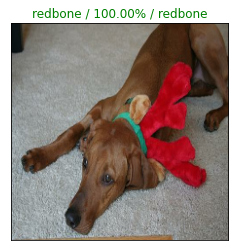

In [22]:
plot_pred(preds,unbatched_label,unbatched_image, 10)

Truth Label =  redbone


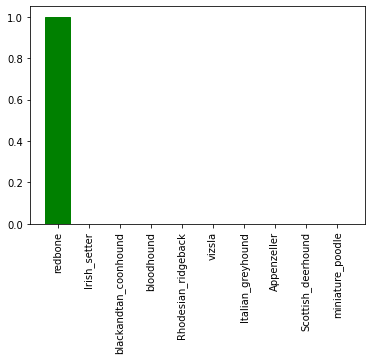

In [23]:
plot_pred_conf(preds, unbatched_label, 10)

## Reloading a trained model

In [24]:
# Create a function to load model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer" : hub.KerasLayer})
  return model

In [25]:
# Load a model trained on 1200 images
loaded_1200_image_model = load_model("Models/2022_08_15-06_28_1660544933-MobileNetV3_100_Adam_20580")

Loading saved model from: Models/2022_08_15-06_28_1660544933-MobileNetV3_100_Adam_20580


In [185]:
loaded_1200_image_model.evaluate(valid_data)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              5508713   
_________________________________________________________________
dense_1 (Dense)              (None, 120)               120240    
Total params: 5,628,953
Trainable params: 120,240
Non-trainable params: 5,508,713
_________________________________________________________________


# Fine-tuning the model
## To start off, lets try training 1200 images first. (10 of each class for balance)
We don't repetitively train the entire image data because it will take time and won't be efficient for the finetuning process.
Therefore, starting with smaller amounts would be Faster and more convenient for finetuning.

We will be taking these images from the `./experiment_data/` folder which will created below.

# Data Augmentation for further improvement on model (Enrichment of training data)